# Analyzer augmentations
All analyzers implemented in ExplainableAI.jl can be augmented by two types of augmentations:
`NoiseAugmentation`s and `InterpolationAugmentation`s.
These augmentations are wrappers around analyzers
that modify the input before passing it to the analyzer.

We build on the basics shown in the *Getting started* section
and start out by loading the same pre-trained LeNet5 model and MNIST input data:

In [1]:
using ExplainableAI
using VisionHeatmaps
using Zygote
using Flux

using BSON # hide
model = BSON.load("../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.344 KiB.

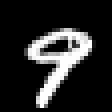

In [2]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

convert2image(MNIST, x)

## Noise augmentation
The `NoiseAugmentation` wrapper computes explanations averaged over noisy inputs.
Let's demonstrate this on the `Gradient` analyzer.
First, we compute the heatmap of an explanation without augmentation:

In [3]:
analyzer = Gradient(model)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.542044692993164, 0.5190736373901367, 0.18255157775878905) RGB(0.5405419067382813, 0.5186877868652343, 0.18299835205078127) … RGB(0.5501000518798829, 0.5211419052124023, 0.18022431030273436) RGB(0.5480906158447265, 0.5206259689331054, 0.18076740112304687); RGB(0.5577551651000977, 0.5230979751586914, 0.1782020248413086) RGB(0.5673554992675781, 0.5255300598144531, 0.17589942016601562) … RGB(0.550458218383789, 0.5212338668823242, 0.18012750854492188) RGB(0.5480906158447265, 0.5206259689331054, 0.18076740112304687); … ; RGB(0.5540689025878907, 0.5221609344482422, 0.17915164794921876) RGB(0.5669629669189453, 0.5254306182861328, 0.17598839416503906) … RGB(0.5511143676757813, 0.5214023376464844, 0.1799501708984375) RGB(0.5480906158447265, 0.5206259689331054, 0.18076740112304687); RGB(0.5480906158447265, 0.5206259689331054, 0.18076740112304687) RGB(0.5480906158447265, 0.5206259689331054, 0.18076740112304687) … RGB(0.5480906158447265, 

Now we wrap the analyzer in a `NoiseAugmentation` with 10 samples of noise.
By default, the noise is sampled from a Gaussian distribution
with mean 0 and standard deviation 1.

In [4]:
analyzer = NoiseAugmentation(Gradient(model), 50)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.5014411338806153, 0.5082617118835449, 0.19722686080932617) RGB(0.5035617301940918, 0.5088291954040528, 0.19636070175170897) … RGB(0.5040299102783202, 0.5089544830322266, 0.19616947326660156) RGB(0.505853662109375, 0.5094425292968751, 0.1954478515625); RGB(0.5025193618774414, 0.5085502517700196, 0.19678645782470702) RGB(0.506331430053711, 0.5095703826904298, 0.19525943603515622) … RGB(0.5083881072998047, 0.5101207611083984, 0.19444835205078126) RGB(0.5084693603515624, 0.5101425048828125, 0.19441630859374998); … ; RGB(0.505416845703125, 0.509325634765625, 0.1956201171875) RGB(0.5038426490783692, 0.508904370880127, 0.1962459602355957) … RGB(0.49956760101318354, 0.5077603439331054, 0.19799210662841799) RGB(0.5021954330444336, 0.5084635665893554, 0.19691876678466796); RGB(0.5062358764648437, 0.5095448120117188, 0.195297119140625) RGB(0.5073607437133789, 0.5098458328247071, 0.1948535095214844) … RGB(0.5005621925354004, 0.5080265022

Note that a higher sample size is desired, as it will lead to a smoother heatmap.
However, this comes at the cost of a longer computation time.

We can also set the standard deviation of the Gaussian distribution:

In [5]:
analyzer = NoiseAugmentation(Gradient(model), 50, 0.1)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.5184866821289063, 0.5128228744506836, 0.19056869812011717) RGB(0.5174648315429687, 0.5125497436523437, 0.19095562744140623) … RGB(0.5219658325195312, 0.513740983581543, 0.18931233825683594) RGB(0.520623193359375, 0.5133866760253907, 0.18979718017578126); RGB(0.5195893798828124, 0.5131138641357422, 0.19017050170898436) RGB(0.5188524169921875, 0.5129193878173829, 0.19043662719726562) … RGB(0.5247163696289062, 0.5144668197631836, 0.18831908874511719) RGB(0.5222234619140624, 0.513808969116211, 0.18921930541992188); … ; RGB(0.5173195510864258, 0.5125108657836914, 0.19101087493896482) RGB(0.5229295532226562, 0.5139952987670899, 0.18896432800292967) … RGB(0.5191868408203124, 0.5130076385498047, 0.19031586303710937) RGB(0.519192333984375, 0.5130090881347656, 0.19031387939453123); RGB(0.5216149291992187, 0.5136483840942383, 0.18943905334472655) RGB(0.523409765625, 0.514122021484375, 0.18879091796874997) … RGB(0.5184262573242188, 0.512

When used with a `Gradient` analyzer, this is equivalent to `SmoothGrad`:

In [6]:
analyzer = SmoothGrad(model, 50)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.4745148376464844, 0.5008291458129882, 0.208893017578125) RGB(0.4761860961914063, 0.5012961151123047, 0.20810654296875003) … RGB(0.475325927734375, 0.5010557739257813, 0.208511328125) RGB(0.4758277618408203, 0.5011959922790528, 0.2082751708984375); RGB(0.47242112121582025, 0.5002441368103028, 0.20987829589843748) RGB(0.46986946105957034, 0.4995311729431152, 0.2110790771484375) … RGB(0.4893320785522461, 0.5048915641784668, 0.20232910919189454) RGB(0.48089237060546874, 0.5025921020507812, 0.20599183349609373); … ; RGB(0.47668389282226564, 0.5014332458496094, 0.20788259887695312) RGB(0.4847310119628906, 0.5036427032470703, 0.20430099487304687) … RGB(0.46168177108764646, 0.49726796493530273, 0.21490300827026368) RGB(0.4695659118652344, 0.49944635772705076, 0.211221923828125); RGB(0.4789643798828125, 0.5020612060546874, 0.20685803222656252) RGB(0.4752770568847656, 0.5010421188354492, 0.208534326171875) … RGB(0.4713200744628906, 0.4

We can also use any distribution from
[Distributions.jl](https://github.com/JuliaStats/Distributions.jl),
for example Poisson noise with rate $\lambda=0.5$:

In [7]:
using Distributions

analyzer = NoiseAugmentation(Gradient(model), 50, Poisson(0.5))
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.40904267120361326, 0.4822663192749024, 0.24153921813964843) RGB(0.40863339614868166, 0.4821466850280761, 0.2417533004760742) … RGB(0.41183256530761714, 0.48304594116210936, 0.24007988891601562) RGB(0.41054592514038085, 0.4826896408081055, 0.24075290069580074); RGB(0.409770767211914, 0.48247498168945313, 0.24115836791992187) RGB(0.4132428855895996, 0.483436491394043, 0.23934218292236326) … RGB(0.41990782546997074, 0.48534228744506835, 0.23585590667724607) RGB(0.4138800315856933, 0.48361293182373044, 0.2390089065551758); … ; RGB(0.4071919326782226, 0.4817253341674804, 0.2425072967529297) RGB(0.4067343063354492, 0.4815915664672852, 0.24274667053222654) … RGB(0.40527256011962887, 0.4811642868041992, 0.24351127624511718) RGB(0.4044916000366211, 0.4809360061645508, 0.24391977844238283); RGB(0.40730961227416995, 0.4817597328186035, 0.24244574127197266) RGB(0.4051712951660157, 0.4811346862792969, 0.24356424560546874) … RGB(0.40270602

Is is also possible to define your own distributions or mixture distributions.

`NoiseAugmentation` can be combined with any analyzer type from the Julia-XAI ecosystem,
for example `LRP` from [RelevancePropagation.jl](https://github.com/Julia-XAI/RelevancePropagation.jl).

## Integration augmentation
The `InterpolationAugmentation` wrapper computes explanations
averaged over `n` steps of linear interpolation between the input and a reference input,
which is set to `zero(input)` by default:

In [8]:
analyzer = InterpolationAugmentation(Gradient(model), 50)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); … ; RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.3194890045166

When used with a `Gradient` analyzer, this is equivalent to `IntegratedGradients`:

In [9]:
analyzer = IntegratedGradients(model, 50)
heatmap(input, analyzer)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); … ; RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) … RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156); RGB(0.26731090087890624, 0.43895178527832035, 0.31948900451660156) RGB(0.26731090087890624, 0.43895178527832035, 0.3194890045166

To select a different reference input, pass it to the `analyze` function
using the keyword argument `input_ref`.
Note that this is an arbitrary example for the sake of demonstration.

In [10]:
matrix_of_ones = ones(Float32, size(input))

analyzer = InterpolationAugmentation(Gradient(model), 50)
expl = analyzer(input; input_ref=matrix_of_ones)
heatmap(expl)

1-element Vector{Array{ColorTypes.RGB{Float64}, 3}}:
 [RGB(0.4490871696472168, 0.49369636154174806, 0.22110631942749023) RGB(0.44208317718505863, 0.49171015472412116, 0.22455604705810545) … RGB(0.41876847076416013, 0.485009245300293, 0.23645187683105467) RGB(0.44284696655273437, 0.49192675170898437, 0.22417985229492185); RGB(0.44949763870239257, 0.4938127632141114, 0.22090414810180664) RGB(0.4431518791198731, 0.4920132194519043, 0.22402967147827146) … RGB(0.4489227264404297, 0.49364972839355475, 0.22118731384277343) RGB(0.44284696655273437, 0.49192675170898437, 0.22417985229492185); … ; RGB(0.4539996612548828, 0.4950894561767578, 0.21868673400878905) RGB(0.47183586425781254, 0.5000806091308594, 0.21015371093750002) … RGB(0.4439007423400879, 0.49222558364868163, 0.2236608283996582) RGB(0.44284696655273437, 0.49192675170898437, 0.22417985229492185); RGB(0.44284696655273437, 0.49192675170898437, 0.22417985229492185) RGB(0.44284696655273437, 0.49192675170898437, 0.22417985229492185) … RGB(

Once again, `InterpolationAugmentation` can be combined with any analyzer type from the Julia-XAI ecosystem,
for example `LRP` from [RelevancePropagation.jl](https://github.com/Julia-XAI/RelevancePropagation.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*